**Import necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

**Data Preprocessing Pipeline**

In [27]:
# 1. Data Preprocessing
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'path_to_train_data',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'path_to_test_data',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
# 2. Transfer Learning with EfficientNet (can switch with ResNet)
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  weights='imagenet')

# Freeze the base model
base_model.trainable = False

# 3. Add Attention Mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.w = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.w) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        weighted_output = inputs * attention_weights
        return weighted_output

# 4. Build Model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Apply attention
x = Attention()(x)

x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes: glioma, meningioma, no tumor, pituitary

model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train the Model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# 7. Fine-tune the Model
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=test_generator
)

# 8. Plot Accuracy
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# 9. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

**Build Model**

In [28]:
# Build CNN Model
model = Sequential()

# First convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

In [29]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.6093 - loss: 0.9551 - val_accuracy: 0.7188 - val_loss: 0.6438
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - loss: 0.6722 - val_accuracy: 0.8889 - val_loss: 0.6342
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6680 - loss: 0.6466
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5312 - loss: 0.6564 - val_accuracy: 0.7188 - val_loss: 0.5694
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.6729 - loss: 0.6387 - val_accuracy: 0.8333 - val_loss: 0.4817
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.5121  
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.7217 - loss: 0.6094 - val_accuracy: 0.7188 - val_loss: 0.5658
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7273 - loss: 0.5562 - val_accuracy: 0.7778 - val_loss: 0.5344
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7357 - loss: 0.

**Evaluate and Visualize Results**

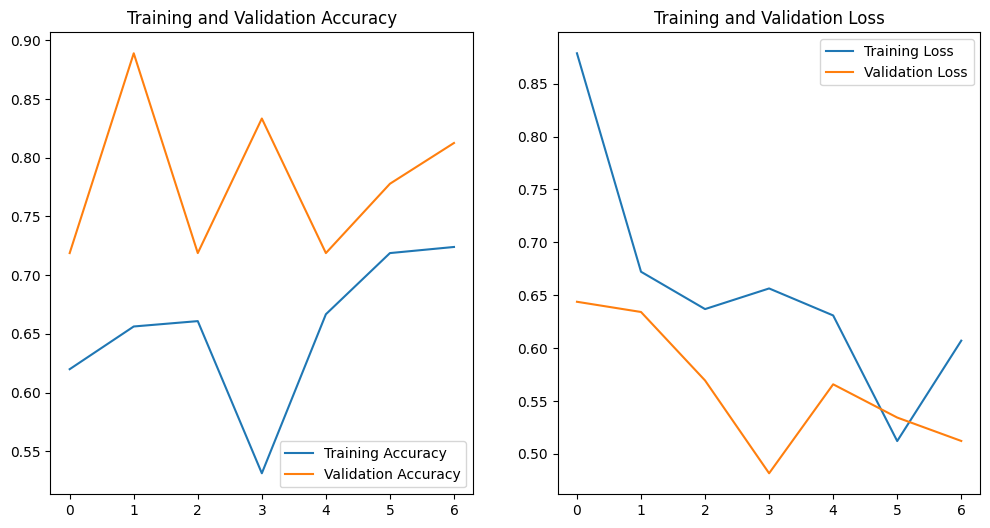

Training Accuracy: 0.75


In [30]:
# Plot the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust epochs_range to match the length of acc and val_acc
epochs_range = range(len(val_acc))  # Ensure this matches the length of val_acc

plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:len(val_acc)], label='Training Accuracy')  # Match lengths of acc and val_acc
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[:len(val_acc)], label='Training Loss')  # Match lengths of loss and val_loss
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# 1. Training Accuracy
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy:.2f}")

**Save the Model**

In [11]:
# Save the model
model.save('brain_tumor_detection_model.keras')

**Use the Model for Predictions**

In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('brain_tumor_detection_model.keras')

# Load new image and preprocess it
img_path = 'with.jpeg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
if prediction[0] > 0.5:
    print("Tumor detected")
else:
    print("No tumor detected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Tumor detected
